---
title: "Precise Point Positioning in GNX-py"
bibliography: ../bibliography.bib
---

# Table of Contents
1. [PPP in GNX-py](#ppp-in-gnx-py)
2. [Parameters estimation in PPP](#parameters-estimation-in-ppp)
3. [Overview of PPP module](#overview-of-ppp-module)
4. [Example 1 - Conventional PPP](#example-1-conventional-ppp)
5. [Example 2 - Undifferenced & Uncombined PPP](#example-2-undifferenced--uncombined-ppp)
6. [References](#references)


# PPP in GNX-py
In this tutorial, I will discuss the PPP module of the GNX-py library. Since the core of the PPP technique is the use of the Kalman filter [@Kouba2001] , I will first discuss the basic information about this algorithm and its application in PPP. For detailed information about the Kalman filter, its implementation methods, and its variants, I encourage you to refer to the guide [@Labbe2020]. The FilterPy library discussed there has been integrated into GNX-py, and one of the classes of this library - ExtendedKalmanFilter, is used for PPP implementation in GNX-py. I will also discuss the corrections I use, such as ionosphere models, troposphere models, satellite clocks, etc. This will help you understand how to process GNSS observations and what happens during parameter estimation. Next, I will discuss the structure of the GNX-py module and provide several examples of the use of positioning algorithms implemented in the library.



## Parameters estimation in PPP



**Observation model:**

For each satellite $s$ and frequency $i$ code and phase observations at a single frequency can be written as [@Handbook]:


$$
\begin{aligned}
C_i &= \rho^s_r
 + (\Delta_{PCO,i}^{rcv} - \Delta_{PCO,i}^s)
 - c(dt^s - dt_r)
 + \gamma_i I
\\ &\quad
 + T + me_{wet} ZTD + \Delta_{ah}
 + \rho_{rel} + e^s_r\,\delta_{tides}
 + OSB_{C_i} + \varepsilon_{C_i}
\\[1ex]
L_i &= \rho^s_r
 + (\Delta_{PCO,i}^{rcv} - \Delta_{PCO,i}^s)
 - c(dt^s - dt_r)
 - \gamma_i I
\\ &\quad
 + T + me_{wet} ZTD + \Delta_{ah} + \rho_{rel}
 + e^s_r\,\delta_{tides}
 + OSB_{L_i} + \lambda_i N_i + \lambda_i phw + \varepsilon_{L_i}
\end{aligned}
$$


where:

$C_{i}$ — code pseudorange observation

$L_{i}$ — carrier phase observation

$\rho_i$ — geometric distance between satellite $s$ and receiver $r$

$\Delta_{PCO,i}^{r}$ - reciever phase center offset

$\Delta_{PCO,i}^{s}$ - satellite phase center offset

$c$ — speed of light

$d_{ts,i}$ — satellite clock offset

$dt_{r}$ - reciever clock offset

$T_i$ — slant tropospheric delay

$me_{wet}$ - mapping function

$ZTD$ - zenith tropospheric delay

$\Delta_{ah}$ - antenna height

$\rho_{rel}$ - relativistic path range correction

$e^{s}_{r}$ - line-of-sight unit vector

$\delta_{tides}$ solid tides displacement correction

$OSB_{C_i}$  / $OSB_{L_i}$ - observable specific satellite hardware bias

$\lambda_{i}$ — carrier phase wavelength at frequency $i$

$N_i$ — ambiguity for satellite $i$

$phw$ - carrier phase wind-up correction

$\varepsilon^C_i, \varepsilon^L_i$ — measurement noise



Ionosphere-free observations, that are free from the influence of the ionosphere are recorded as [@Handbook] :


$$
\begin{aligned}
C_{IF} &= \frac{f_1^2}{(f_{1}^{2} - f_{2}^{2})} \, C1
        - \frac{f_2^2}{(f_{1}^{2} - f_{2}^{2})} \, C2
\\[0.7ex] &\quad
= \rho^{s}_{r}
 + (\Delta_{PCO,IF}^{rcv} - \Delta_{PCO,IF}^{s})
 - c(dt^{s}-dt_{r})
 + T + me_{wet}\, ZTD
\\[0.7ex] &\quad
+ \Delta_{ah} + \rho_{rel}
 + e^{s}_{r}\, \delta_{tides}
 + \varepsilon_{C_{IF}}
\\[2ex]
L_{IF} &= \frac{f_1^2}{(f_{1}^{2} - f_{2}^{2})} \, L1
        - \frac{f_2^2}{(f_{1}^{2} - f_{2}^{2})} \, L2
\\[0.7ex] &\quad
= \rho^{s}_{r}
 + (\Delta_{PCO,IF}^{rcv} - \Delta_{PCO,IF}^{s})
 - c(dt^{s}-dt_{r})
 + T + me_{wet}\, ZTD
\\[0.7ex] &\quad
+ \Delta_{ah} + \rho_{rel}
 + e^{s}_{r}\, \delta_{tides}
 + \varepsilon_{L_{IF}}
 + \lambda_{IF} N_{IF}
\end{aligned}
$$





The PPP technique enables the positioning of a single receiver using phase and code observations with sub-centimeter accuracy [@Kouba2001; @Glaner2022; @Schoenemann2014].  The accuracy of the final position depends on the quality of the orbit models, clocks, and corrections used. PPP positioning involves determining a number of unknown parameters. For the purposes of this introduction, we will consider the case of a conventional model, in which code and phase observations are combined into ionosphere-free observations in which first-order ionospheric delay is eliminated. In this situation, our state vector contains the following parameters:


$$\begin{aligned}
\mathbf{x} =
\begin{bmatrix}
X & Y & Z & d_{tr} & isb & ztd & N_1 & N_2 & \dots & N_n
\end{bmatrix}^\mathrm{T}
\end{aligned}$$


where


$X, Y, Z$ — receiver coordinates (ECEF)
$dt_{r}$ — receiver clock offset
$ztd$ — zenith tropospheric delay
$isb$ - Inter system bias\
$N_i$ — carrier phase ambiguity for satellite $i$



$X, Y, Z$, and $dt_{r}$ are the reciever coordinates and offset of the receiver clock, $isb$ is the inter-system bias—in the case of processing data from two GNSS constellations at once, it reflects the difference in the time reference system and receiver delays between the processed signals from different GNSS. $N_i$ are phase ambiguities for a $i-th$ satellite. This is the total number of phase cycles on the satellite-receiver path. During estimation, it is determined as a floating point number.



**EKF prediction:**

Let's discuss the process of parameter estimation using the Extended Kalman Filter. We assume that we have access to a time series of GNSS observations from a given receiver. We call what we measure a state: our state is the estimated parameters. The Kalman filter, in very simple terms, combines the prediction of the state of our system with the state obtained from measurements. Filtration is performed sequentially: in each epoch, we process the measurements available in that epoch and perform a prediction and update step. Let's first discuss the prediction step and look at the equations:


$$\begin{aligned}
\hat{\mathbf{x}}_{k} = \mathbf{F} \hat{\mathbf{x}}_{k-1}
\end{aligned}$$

$$\begin{aligned}
\mathbf{P}_{k|k-1} = \mathbf{F}_{k-1} \mathbf{P}_{k-1|k-1} \mathbf{F}_{k-1}^\mathrm{T} + \mathbf{Q}_{k-1}
\end{aligned}$$


$\hat{\mathbf{x}}_{k}$ and $\hat{\mathbf{x}}_{k-1}$ are our state vectors in epochs $k$ and $k-1$, respectively. This vector contains the parameters discussed at the beginning of this section, i.e., the receiver and satellite parameters.


Matrix $F$ is the so-called state transition matrix. The $F \, x$ operation is intended to map the predicted evolution of the state between adjacent epochs. Matrix $F$ is an element of the process model, i.e., it is a mathematical representation of our knowledge or assumptions about the behavior of the system. Let's illustrate this with an example. Assuming the state vector discussed above and a stationary GNSS receiver, we can make the following assumptions about our system: 

- the position of the receiver does not change 
- we do not know the characteristics of the clock - we assume white noise with high variance 
- we assume that isb is constant over time
- we assume that ZTD can be described as a random walk 
- satellite uncertainties are constant, assuming that cycle slips have already been eliminated

- In this case, the matrix $F$ will look like this:


$$\begin{aligned}
\mathbf{F} =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & \cdots & 0 \\
0 & 0 & 0 & 0 & 0 & 1 &        & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots &        & \ddots & \vdots \\
0 & 0 & 0 & 0 & 0 & 0 & \cdots & 1 \\
\end{bmatrix}
\end{aligned}$$

Each column of the matrix corresponds to a pramater in vector X. Try multiplying an example vector, even a 3 or 4 element vector, by a similar matrix on a piece of paper—you will see that after multiplication you will get the same vector (except for the clock, but we will get to that in a moment). This is the task of the matrix $F$ - it reflects our predicted behavior of the system during the passage of one epoch.


The P matrix is an a-priori error matrix of the state vector elements. In the prediction step, the variance is propagated to the next epoch. The Q matrix, or process noise matrix, reflects our uncertainty about the process model. In other words, the Q matrix reflects our confidence in the accuracy of the description of the system's behavior by the F matrix. Assuming that we are certain that the receiver is stationary and modeling the clock as white noise, the first three diagonal elements of the Q matrix will be equal to zero (for coordinates), while for the clock we can set the variance to a very large value (e.g., 1e8, 1e9, etc.). We assume that the process model accurately describes the ambiguities and ISB as constant over time, so the corresponding elements of the Q matrix are also equal to zero. We model ZTD as a random walk—the variance could be, for example, 2-3 mm/h.


$$\begin{aligned}
\mathbf{Q} =
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & 1^9 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & 0 & 0 &  &   2e^{-3}\,\frac{\Delta_t}{3600}     & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots &        & \ddots & \vdots \\
0 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
\end{bmatrix}
\end{aligned}$$



**EKF update:**

In the update step, we apply our measurements into the model and combine information about the measurements and their accuracy with information about the predicted state of the system and the accuracy of this prediction.


$$\begin{aligned}
\mathbf{y}_k &= \mathbf{z}_k - \mathbf{h}(\hat{\mathbf{x}}_{k|k-1}) \\
\mathbf{S}_k &= \mathbf{H}_k \mathbf{P}_{k|k-1} \mathbf{H}_k^\mathrm{T} + \mathbf{R}_k \\
\mathbf{K}_k &= \mathbf{P}_{k|k-1} \mathbf{H}_k^\mathrm{T} \mathbf{S}_k^{-1} \\
\hat{\mathbf{x}}_{k|k} &= \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k \mathbf{y}_k \\
\mathbf{P}_{k|k} &= (\mathbf{I} - \mathbf{K}_k \mathbf{H}_k) \mathbf{P}_{k|k-1}
\end{aligned}$$


where  
$\mathbf{y_k}$ - prefit residuals   
$\mathbf{z}_k$ — vector of observed measurements at epoch $k$  
$\mathbf{h}(\cdot)$ — nonlinear measurement function  
$\mathbf{H}_k$ — Jacobian of $\mathbf{h}$ with respect to $\mathbf{x}$    
$\mathbf{R}_k$ — measurement noise covariance  
$\mathbf{S_k}$ - prefit residuals covariance matrix    
$\mathbf{K_k}$ - Kalman gain   
$\mathbf{Q}_{k-1}$ — process noise covariance  
$\mathbf{\hat{x_k}}$ - updated state vector  
$\mathbf{P_{k|k}}$ - updated a-priori covariance matrix  


Prefit residuals are the difference between measurements and predicted measurements. In our case, this is the difference between GNSS observations, $\mathbf{z_k}$, corrected for all available corrections, and calculated (predicted) observations. The function $\mathbf{h}(\cdot)$ is a function that maps the elements of the state vector to observations. In our case, predicted pseudorange and phase observation, denoted by $\hat{z_{C_i}}$ and $\hat{z_{L_i}}$ are computed as:

$$\begin{aligned}
\hat{z_{C_i}} = \rho - (dt_{r} + isb) - me_{wet}\, ZTD\\
\hat{z_{L_i}} = \rho - (dt_{r} + isb) - me_{wet}\, ZTD - \lambda_i \, N_i
\end{aligned}$$


Where $dt_r$, $isb$, $ZTD$ and $N_i$ are predicted elements of state vector


The Jacobian matrix is a design matrix—as in standard LSQ, each column contains the partial derivatives of the observation equation with respect to a given element of the state vector. 


$$\begin{aligned}
\mathbf{H}_k = 
\begin{bmatrix}
\frac{\partial h_1}{\partial X} & \frac{\partial h_1}{\partial Y} & \frac{\partial h_1}{\partial Z} & \frac{\partial h_1}{\partial d_{tr}} & \frac{\partial h_1}{\partial \mathrm{ISB}} & \frac{\partial h_1}{\partial ztd} & \frac{\partial h_1}{\partial N_1} & 0 & \cdots & 0 \\
\frac{\partial h_2}{\partial X} & \frac{\partial h_2}{\partial Y} & \frac{\partial h_2}{\partial Z} & \frac{\partial h_2}{\partial d_{tr}} & \frac{\partial h_2}{\partial \mathrm{ISB}} & \frac{\partial h_2}{\partial ztd} & 0 & \frac{\partial h_2}{\partial N_2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
\frac{\partial h_m}{\partial X} & \frac{\partial h_m}{\partial Y} & \frac{\partial h_m}{\partial Z} & \frac{\partial h_m}{\partial d_{tr}} & \frac{\partial h_m}{\partial \mathrm{ISB}} & \frac{\partial h_m}{\partial ztd} & 0 & 0 & \cdots & \frac{\partial h_m}{\partial N_m} \\
\end{bmatrix}
\end{aligned}$$



Assuming that we are processing code and phase observations from two GNSS systems, each row of the $\mathbf{H_k}$ matrix corresponds to a given observation from the $\mathbf{z}$ vector. The partial derivatives with respect to ambiguities are equal to zero for code observations, and similarly, derivative with respect to ISB is equal to zero for the reference constellation for the receiver clock (GPS by default). Assuming that for each satellite we process one IF code observation and one IF phase observation, the vector $\mathbf{z}$ and the matrix $\mathbf{h_k}$ will have dimensions of $N \cdot 2$ and ($N \cdot 2$, 5+N), respectively, where N is the number of satellites visible at a given epoch and 5 stands for 5 default parameters: station position vector elements, clock offset, ZTD and ISB.


The R matrix is a diagonal matrix of measurement variances. In GNX-py you can customize code variances and phases, although I can only vouch for the default values I used for positioning classes. For code and phase observations, we adopt the following error model:

$$\begin{aligned}
\sigma= a + \frac{b}{sin(elev)}
\end{aligned}$$

Where a is equal to $1$ and $1^{-4}$, and b is equal to $3^{-3}$ and $2.5^{-4}$  meters for code and phase observations, respectively.

$\mathbf{S_k}$, as shown above, is the covariance matrix of observation residuals. The $\mathbf{K_k}$ - Kalman gain we can intuitively represent as a measure of our “confidence” in the state vector estimate relative to the prediction. A small gain means little “confidence” in the measurements. In the equation for the updated state vector $\hat{x_k}$, in the action $\mathbf{K}_k \mathbf{y}_k$ we weight the difference of measurements and predicted measurements by a measure of our confidence in measurements/uncertainty about predictions.

In GNX-py the approach to matrix composition is as follows: it stacks matrices in GPS and Galileo order, and within systems in code, phase order. This isn't particularly significant, but I mentioned it here for clarity. Notice the matrix H; I've listed the derivatives with respect to all components of the estimated state vector. Naturally, the code observations have a 0 in the derivative over the ambiguity, just as Galileo phase observations have zeros in the column designated for GPS phase ambiguities, and vice versa.

## Overview of PPP module
We have already discussed the basics of the Kalman filter, here we will proceed to demonstrate the use of GNX-py to perform precise point positioning. We will start by discussing the module responsible for PPP positioning and then present two examples of use.


The multi-step preprocessing of the observations and the positioning itself is hidden in the library in the PPPSession class. The only required argument of this class is an instance of the configuration class - PPPConfig. This class contains a number of parameters that define the processing strategy. I will discuss the most important of them and recommend that you see the class in person in the /config module. There each parameter is briefly presented. Let's import the library and use the data in the ./data directory, and then see how to set the positioning strategy.

In [1]:
import gnx_py as gnx
import numpy as np

Below we define the path to our observation file, the path to the broadcast file, .ATX, .BIA, and a list of paths to the three SP3 files. We use the previous day's and next day's files by default, so that the interpolation functions can find the right window to interpolate the coordinates to the specified epochs. We also create a set with the designations of the systems we want to use : G stands for GPS, and E for Galileo. These abbreviations are used in all gnx-py modules. In addition, we also specify the day of measurement as DOY. The SINEX file is optional, but when provided, if it contains the coordinates of the station we are processing, its coordinates from the file will serve as a reference.




In [2]:
OBS_PATH='../data/BOR100POL_R_20240350000_01D_30S_MO.rnx'
NAME = OBS_PATH.split('/')[-1][:4]
NAV = '../data/BRDC00IGS_R_20240350000_01D_MN.rnx'
SP3_LIST=[
'../data/COD0OPSFIN_20240340000_01D_05M_ORB.SP3',
'../data/COD0OPSFIN_20240350000_01D_05M_ORB.SP3',
'../data/COD0OPSFIN_20240360000_01D_05M_ORB.SP3']
ATX_PATH='../data/ngs20.atx'
DCB_PATH= '../data/COD0OPSFIN_20240350000_01D_01D_OSB.BIA'
GIM='../data/COD0OPSFIN_20240350000_01D_01H_GIM.INX'
SINEX='../data/IGS0OPSSNX_20240350000_01D_01D_CRD.SNX'
OUT='../output'
SYS= {'G','E'}
DOY = 35

As I mentioned, the class "controlling'' our processing is the PPPConfig class. In it we define the parameters that determine the various steps of processing. I will now discuss the most important arguments of the class and how they are used.

- $obs\_path$ - path to the observation file
- $nav\_path$ - the path to the broadcast file - it can be used to screen data based on the satellite health code or to interpolate coordinates. when using ionosphere models such as klobuchar or ntcm, this file is necessary to obtain model coefficients
- $screen$ - do we want to apply the above data screening
- $atx/dcb\_path$ - paths to atx and dcb files. If they are omitted, the associated corrections will not be made, which will degrade the quality of the solution.
- $sp3\_path$ - list of paths to sp3 files
- $sys$ - set with the constellation codes that I discussed above. Note, if you set {“G” , “E”}, i.e. GPS +. Galileo, and Galileo observations are not found in the observation file, because the receiver did not register them, processing will be aborted. In this situation, change to: {“G”}
- The designation of the signals used in the form F1F2, e.g. for GPS: L1L2, L1L5, and for Galileo E1E5a, E1E5b. By default, the program always tries to load two frequencies (L1L2 and E1E5a) in order to detect cycle slips using geometry free combinations.
- $positioning\_mode$ - you can choose “combined”, which is a conventional PPP using ionofree observations, or ‘uncombined’, which is an undifferenced - uncombined approach in which “raw” observations are processed (with two frequencies 4 observations per satellite: two code and two carrier phase), or 'single' - in which single frequency code and phase observations are processed
- $orbit\_type$ - source of satellite coordinates, “broadcast” or “precise”
- $time\_limit$ - datetime list with [$t_0$, $t_1$] allows you to cut observations from the given time interval from $t_0$ to $t_1$
- $sinex\_path$ - the path to the sinex file, if the station coordinates are present in it, they will serve as a reference.
- $ev\_mask$ - cutoff angle of satellite elevation
- $station\_name$ - station code in the form of 4 characters, e.g. BRUX, ZIM2, P051.
- $dcb\_path$ - path to the DCB file
- $sat\_pco$ - whether to use satellite PCO correction, and in which way to apply it: 'los' (line-of-sight projection) or 'crd' - direct satellite coordinates modification
- $reset\_every$ - every how many minutes to reset the filter - useful for testing accuracy. Default is 0 - no resets

- $ionosophere\_model$ - which ionosphere model to use, available = [“gim”, "ntcm", “klobuchar”] or False - no ionosphere model
- $troposphere\_model$: which model to use, available: [“niell”, "collins", “saastamoinen”] or False - no troposphere model
- $min\_arc\_len$: maximum length of satellite arc pass. This parameter is used for cycle slips detection. For given satellite, if time between two cycle slips is shorter than this value, this arc is rejected. Default value is 10 minutes.

You can control the entire estimation process by modifying the elements of matrices P and Q.  For example, $p\_amb$, $p\_crd$, $p\_isb$, $p\_dt$, etc. are diagonal elements of the P matrix corresponding to phase ambiguity, coordinates, ISB, and receiver clock, respectively. Parameters with the prefix $q\_$ are corresponding elements of the Q matrix.

## Example 1 - Conventional PPP

In [3]:
config = gnx.PPPConfig(
    obs_path=OBS_PATH,
    nav_path=NAV,
    sp3_path=SP3_LIST,
    atx_path=ATX_PATH,
    dcb_path=DCB_PATH,
    sinex_path=SINEX,
    gim_path=GIM,
    use_gfz=True,
    output_dir=OUT,
    sys=SYS,
    gps_freq='L1L2',
    gal_freq='E1E5a',

    screen=True,
    orbit_type='precise',

    ionosphere_model=False,
    troposphere_model='niell',
    sat_pco='los',
    rec_pco=True,
    windup=True,
    rel_path=True,
    solid_tides=True,
    antenna_h=True,
    ev_mask=7,
    cycle_slips_detection=True,
    min_arc_len=10,

    station_name=NAME,
    day_of_year=DOY,
    time_limit=None,

    # PPP parameters
    positioning_mode = 'combined',
    trace_filter=False,
    reset_every=0,


)

The class in which all processing and positioning takes place is PPPSession. The only thing we need to pass to it is our configuration file. We also create a logger that will capture information about the steps currently being performed.

In [4]:
controller = gnx.PPPSession(config=config)

To start processing, call the .run() method and wait – it may take a moment. In jupyter notebook, everything usually runs slower than in a script.

In [5]:
results = controller.run()

In [6]:
results.__annotations__

{'solution': "Union['pd.DataFrame', None]",
 'residuals_gps': "Union['pd.DataFrame', None]",
 'residuals_gal': "Union['pd.DataFrame', None]",
 'convergence': 'Union[float, int, None]'}

Our results are a PPPResult class instance, which contains:


- $solution$ - a dataframe with estimated parameters for the station (position, clock, ztd, isb)
- $residuals\_gps$, $residuals\_gal$ - a dataframe containing residuals of code and phase observations, as well as all observation data used in processing, such as raw observations, corrections, coordinates, and satellite clocks
- $convergence$ - this is the measured convergence time. By default, GNX-py measures convergence as the time after which the change in the receiver's position from epoch to epoch does not exceed 5 mm. Although the filter uses a reference position to generate results, I did not implement convergence measurement based on position accuracy there, because I wanted to have a different default indicator, independent of the reference position. In fact, it is currently a measure of the stability or precision of the filter rather than convergence. We will use an external function to measure convergence based on accuracy.


In [7]:
sol = results.solution
print(sol.columns.tolist())

['de', 'dn', 'du', 'dtr', 'isb', 'ztd', 'x', 'y', 'z', 'mx', 'my', 'mz', 'ct_min']


As you can see, in $solutions$ dataframe we have access to the receiver position, ISB, clock offset, and ZTD. In addition, because we used the SINEX file, we also have errors in the topocentric cover in relation to the position from the file. Additionally, we see the columns mx, my, mz, and ct_min - these are, respectively: errors of estimated coordinates (elements of the covariance matrix of the state vector) and convergence time in minutes.

In [8]:
from plotting_tools import df_tail
df_tail(sol,nrows=5,ncols=7)

| time                |     de |    dn |    du |      dtr |   isb |   ztd |
|---------------------|--------|-------|-------|----------|-------|-------|
| 2024-02-04 23:57:30 | -0.002 | 0.000 | 0.044 | 2419.515 | 1.770 | 0.005 |
| 2024-02-04 23:58:00 | -0.002 | 0.000 | 0.044 | 2419.515 | 1.770 | 0.005 |
| 2024-02-04 23:58:30 | -0.002 | 0.000 | 0.044 | 2419.507 | 1.770 | 0.005 |
| 2024-02-04 23:59:00 | -0.002 | 0.000 | 0.044 | 2419.512 | 1.770 | 0.006 |
| 2024-02-04 23:59:30 | -0.002 | 0.000 | 0.044 | 2419.505 | 1.770 | 0.014 |

Let's select data with GPS and Galileo residuals and use the function from the $plotting\_tools.py$ file for visualization. You can use  $plot\_residuals$ function to automatically create a graph of phase and code residuals depending on time or satellite elevation. The function has several additional parameters that improve readability, which are useful in visualizing phase residuals in particular. First, you can skip the first N epochs on the graph ($cut\_init\_time$ parameter). During the first few minutes, the filter is in the initialization phase and the residuals are very large because they contain initial estimates of the clock and other parameters that are subject to large errors, which makes it difficult to see the rest of the residuals. The $skip\_obs$ parameter allows you to skip the first N observations for a given satellite that becomes visible during the filter run - again, for the first few epochs (typically 0-10), the uncertainty is not yet close to its final value, and this also distorts the scale of the graph. Of course, for illustrative purposes, you can disable these options by setting both parameters to 0 - what appears to you as outliers is nothing to worry about. To select a specific observation type, choose $obs\_type = ‘code’ or $‘phase’. You can plot in relation to time or elevation by selecting $x\_axis = ‘time’$ or $‘elev’$.

In [9]:
res = results.residuals_gps
res_gal = results.residuals_gal

In [10]:
from plotting_tools import plot_residuals, plot_positioning_series, plot_uduc_residuals

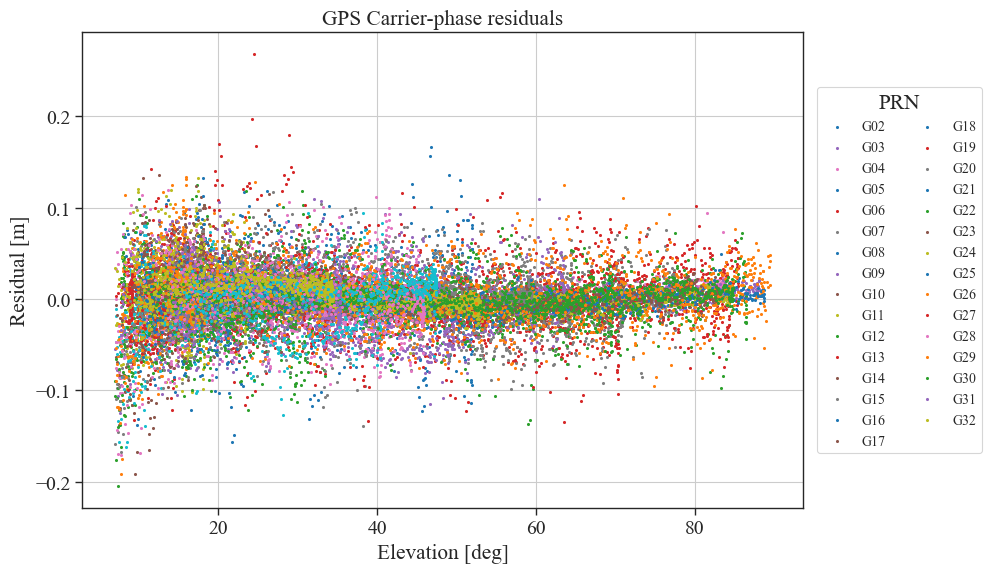

In [11]:
plot_residuals(df=res,obs_type='phase',x_axis='elev',skip_obs=10)

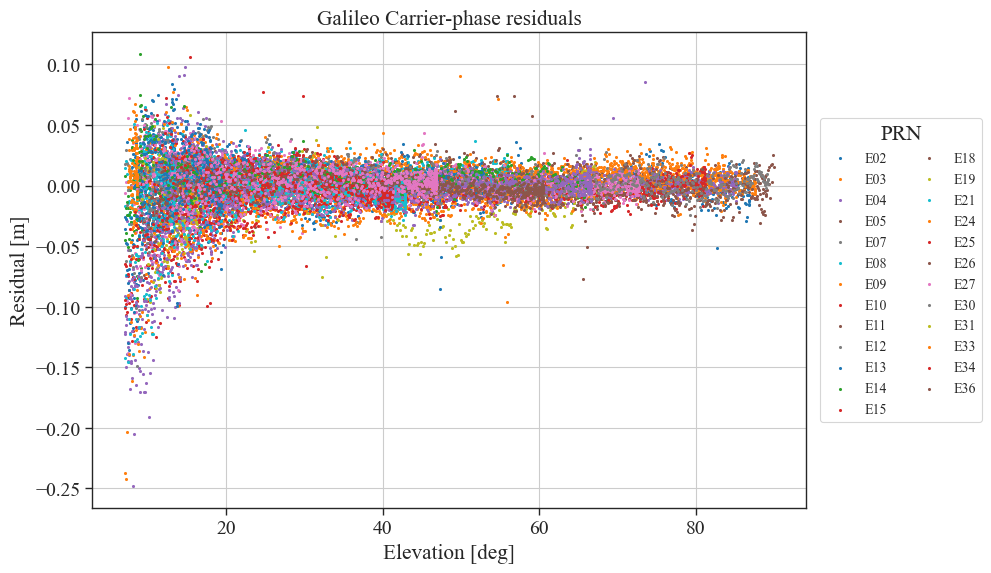

In [12]:
plot_residuals(df=res_gal,obs_type='phase',x_axis='elev',skip_obs=10)

Note that Galileo observations have significantly less noise than GPS. You can process the data as it is — in pandas.DataFrame format, and obtain more statistics and information using standard pandas tools.
You can see an example below:

<Axes: title={'center': 'STD of carrier phase residuals for Galileo'}, xlabel='PRN', ylabel='STD [m]'>

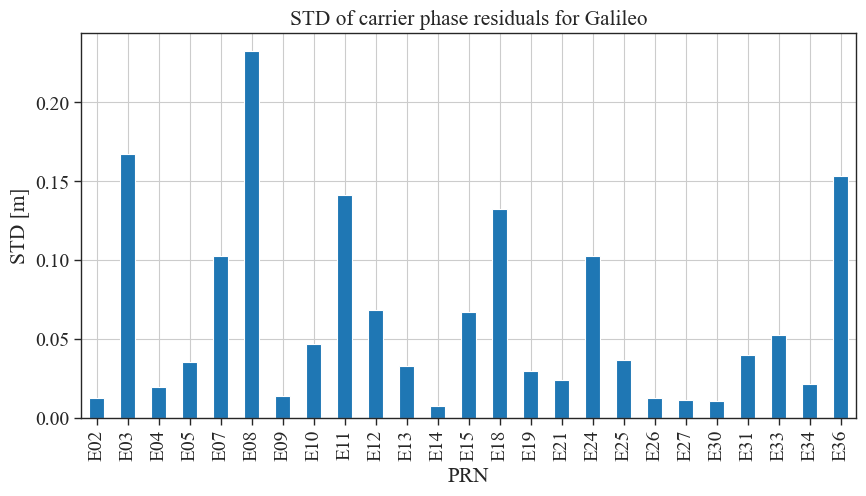

In [13]:
res_gal['prn'] = res_gal.index.get_level_values('sv').str[:3]
res_gal['v_std'] = (
    res_gal
    .groupby("prn")["v"]
    .transform(
        lambda s: s.loc[
            # skip first 10 pbservations (ambiguity initialization time)
            s.index.get_level_values('time').isin(
                res_gal.index.get_level_values('time').unique()[30:]
            ) &
            (np.arange(len(s)) >= 5)
        ].std()
    )
).to_frame()
v_std_summary = res_gal.groupby('prn')['v_std'].first().sort_index()
v_std_summary.plot(kind='bar',title='STD of carrier phase residuals for Galileo',grid=True,figsize=(10,5), ylabel='STD [m]',xlabel='PRN')



I mentioned the convergence indicator earlier. In the $stat\_tools.py$ script, you will find a simple function that measures convergence for a time series based on accuracy. The function takes a convergence accuracy threshold, mode as 3D or 2D, and a minimum stability period, i.e., the number of epochs in which the error remains below the threshold.

In [14]:
from stat_tools import measure_convergence_time

In [15]:
ct = measure_convergence_time(df=sol,threshold=0.1,min_stable_duration=30,mode='2D')

In [16]:
print(f'Convergence time : {ct} min')

Convergence time : 20.75 min


With the plot_position_series function from the plotting_tools file, you can create a default plot of the positioning results and estimated parameters. Additionally, you can mark the convergence time.

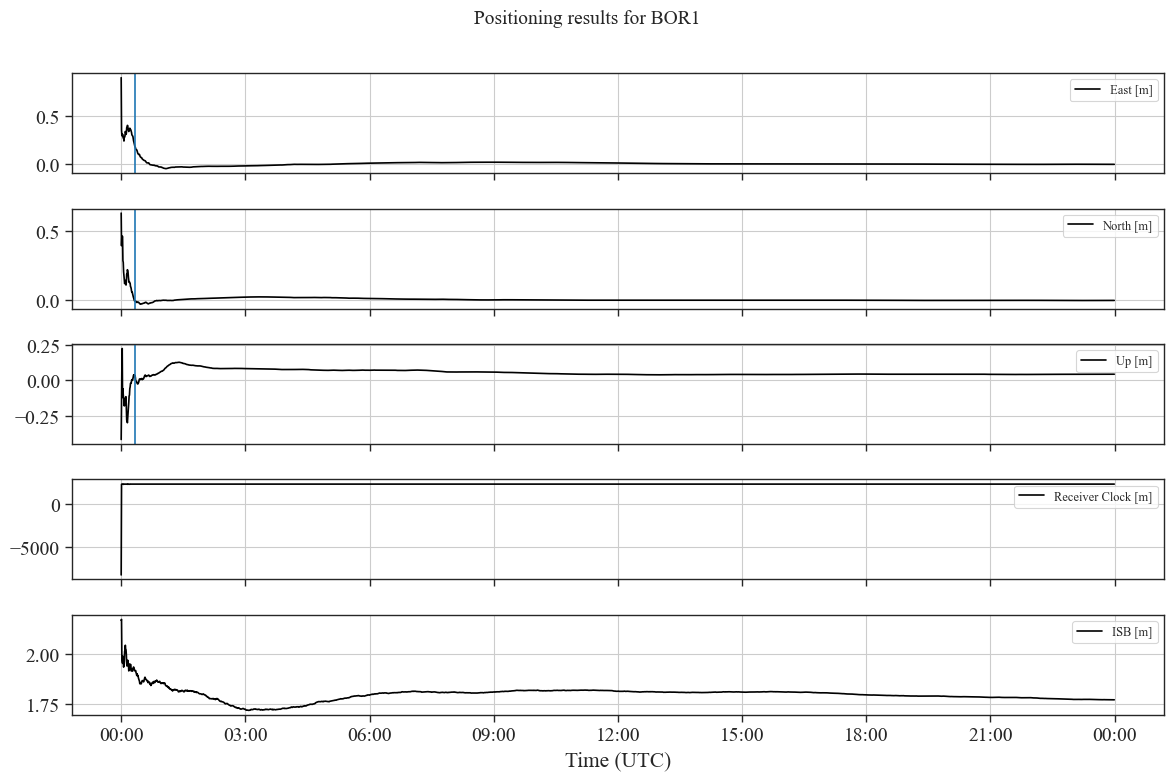

In [17]:
plot_positioning_series(sol=sol,title=f'Positioning results for {NAME}',color='black',ct=ct)

We can see that the filter converges quite quickly, especially in the dN and dU planes. Any inaccuracies in determining the ambiguities mainly affect the East component. Since we use float ambiguity determination, this effect is accentuated. Finally, we obtain a fairly accurate position at the sub-centimeter level horizontally and a few centimeters vertically, which should generally meet our expectations for PPP Float with final products.

## Example 2 - Undifferenced & Uncombined PPP

Let's look at another example. This time, we will use positioning based on the undifferenced uncombined approach. In this approach, we do not eliminate the influence of the ionosphere by IF combinations, but instead introduce raw observations at two frequencies into our system and estimate the ionospheric delay for each observation [@Glaner2022; @Schoenemann2014]. GNX-py currently supports processing two frequencies at a time. Additionally, we can enrich our system of equations by introducing ionospheric constants, which will “stiffen” our system in the initial phase of the filter's operation. These constants are ionospheric constraints derived from an ionosphere model, e.g., from GIM, in the form of ionospheric delays for each satellite. They act as pseudo-observations that help the filter adjust the estimated ionospheric delays. We introduce constants into the equation by setting the use_iono_constr argument to True in the PPPConfig class and selecting the ionosphere model. Since the modeled delays act as constraints, it is important to select the appropriate weights for the observations. In the case of GIM, we have three options:

- consistent use of modeled delay error information based on the RMS maps available in the ionex file;
- use of custom weights;
- a combination of the above 

In GNX-py, the default approach for PPP-UDUC is the third option. Namely, by selecting $use\_iono\_constr$ and $use\_iono\_rms$ and $ionosphere\_model = gim$, we obtain ionospheric delays and their errors. To allow the filter to gradually mitigate the impact of contraints and increasingly “trust” the measurements as the filter progresses, we scale the obtained errors by the parameters $sigma\_iono\_0$, $sigma\_iono\_end$, and $t\_end$. These parameters are coefficients by which the ionospheric pseudo-observation errors are multiplied in each epoch. This approach means that we first treat pseudo-observations with a high degree of confidence (greater than the nominal error value) and at the end of a given period ($t\_end$) with a lower degree of confidence. The default parameters for GIM are 0.15, 2.5, and 20 for $sigma\_iono\_0$, $sigma\_iono\_end$, and $t\_end$, respectively, which represent the initial coefficient, the final coefficient, and the final epoch (in number of epochs, not minutes!).


In the UDUC approach in our system, we have slightly more parameters. First, for each satellite, we have two phase ambiguities: for frequencies $F1$ and $F2$. Second, for each code observation at a given frequency, we have one receiver hardware delay parameter, which is essentially the observable specific code bias of the receiver for a given observation. In addition, we have parameters as in conventional PPP, i.e., coordinates, clock offset, ISB in the case of more than one GNSS system, and ztd.

Currently, in GNX-py, you can use the PPP-UDUC approach in single or multi GNSS mode. We will perform positioning for the data from the previous example and compare the results.

In [18]:
config = gnx.PPPConfig(
    obs_path=OBS_PATH,
    nav_path=NAV,
    sp3_path=SP3_LIST,
    atx_path=ATX_PATH,
    dcb_path=DCB_PATH,
    sinex_path=SINEX,
    gim_path=GIM,
    use_gfz=True,
    output_dir=OUT,
    sys=SYS,
    gps_freq='L1L2',
    gal_freq='E1E5a',

    screen=True,
    orbit_type='precise',

    ionosphere_model='gim',
    use_iono_rms=True,
    troposphere_model='niell',
    sat_pco='los',
    rec_pco=True,
    windup=True,
    rel_path=True,
    solid_tides=True,
    antenna_h=True,
    ev_mask=7,
    cycle_slips_detection=True,
    min_arc_len=10,

    station_name=NAME,
    day_of_year=DOY,
    time_limit=None,

    # PPP parameters
    positioning_mode = 'uncombined',
    trace_filter=False,
    reset_every=0,


)

In [19]:
controller = gnx.PPPSession(config=config)
uncombined_results = controller.run()

In [20]:
unc_sol = uncombined_results.solution

In [21]:
unc_sol.to_csv('../output/unc_sol.csv')

In [22]:
df_tail(unc_sol,nrows=5,ncols=5)

| time                |     de |    dn |    du |      dtr |
|---------------------|--------|-------|-------|----------|
| 2024-02-04 23:57:30 | -0.006 | 0.007 | 0.027 | 2425.699 |
| 2024-02-04 23:58:00 | -0.006 | 0.007 | 0.027 | 2425.592 |
| 2024-02-04 23:58:30 | -0.006 | 0.007 | 0.027 | 2425.783 |
| 2024-02-04 23:59:00 | -0.006 | 0.007 | 0.027 | 2425.646 |
| 2024-02-04 23:59:30 | -0.006 | 0.007 | 0.027 | 2425.661 |

The results are slightly worse in the horizontal plane and nearly 2 cm better in the vertical component. As you can see, in addition to the values present in the state vector in PPP-IF, we also have columns starting with $DCB$. These are the receiver hardware delays I mentioned above. In the estimation process, in order to improve numerical efficiency, I used an approach in which $OSB$ at the reference frequency (L1 and E1) is ‘frozen’, i.e. the value 0 is enforced by assigning this value to the low variance of the process model (matrix Q and P). OSB at the second frequency is determined relative to the reference frequency. Hence, what we obtain is in fact DSB bias - differential signal bias. The process model assumes that the bias affects code and phase observations equally. The OSB of phase observations is assumed to be absorbed by the float ambiguity.

Let us now measure the convergence time. It turns out to be almost three times longer for this station than for IF positioning. This can be explained by the number of unique parameters determined in the epoch, such as ionospheric delays.


In [23]:
ct = measure_convergence_time(df=unc_sol,threshold=0.1,min_stable_duration=30,mode='2D')
print(f'Convergence time : {ct} min')

Convergence time : 62.0 min


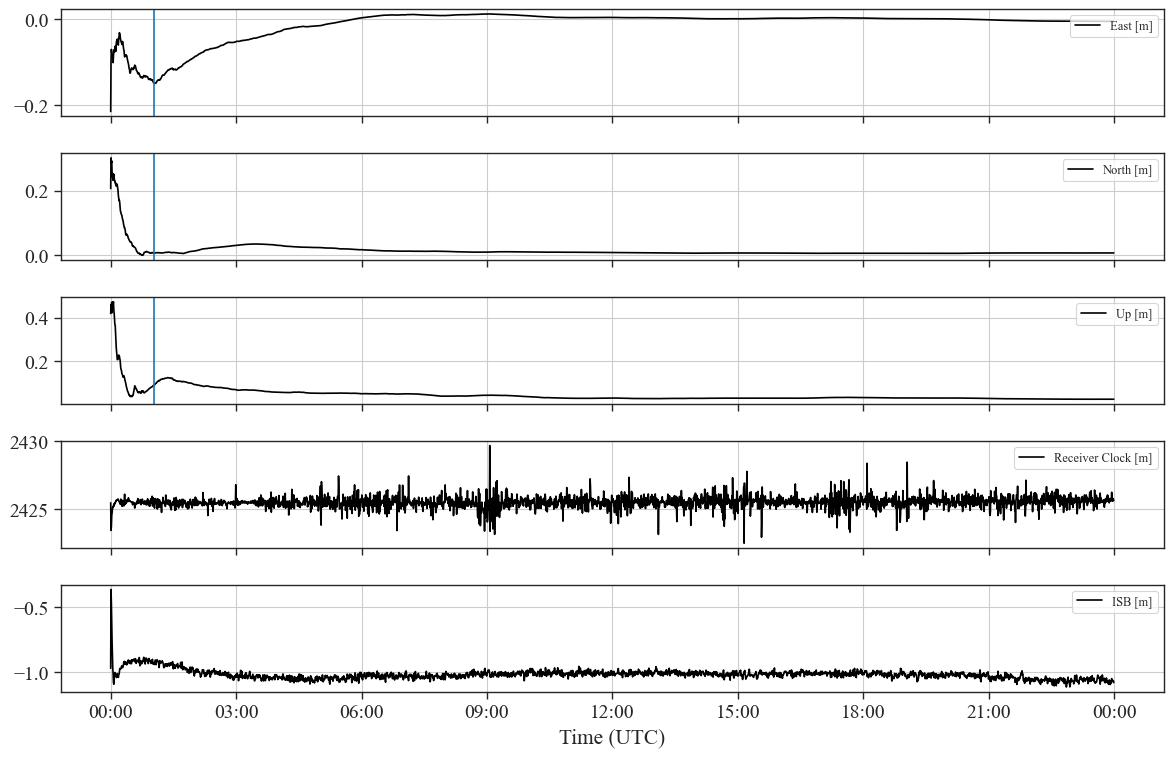

In [24]:
plot_positioning_series(sol=unc_sol,ct=ct,color='black')

Let's take a look at the post-fit residuals. Unlike the IF approach, we have 4 residuals for each satellite in our initial dataframe, corresponding to the number of observations processed. To use them in our function, replace the names according to the pattern in the cell below. The $plot\_residuals$ function is based on the presence of the $v$ column for phase observations and $vc$ for code observations.

In [25]:
residuals = uncombined_results.residuals_gps.copy()

In [26]:
df_tail(residuals[[c for c in residuals.columns if c.startswith(('vc','vl'))]],nrows=5)

| sv      | time                |    vc1 |   vl1 |    vc2 |    vl2 |
|---------|---------------------|--------|-------|--------|--------|
| G17_2_4 | 2024-02-04 23:59:30 | -0.173 | 0.037 |  0.230 |  0.040 |
| G19_3_6 | 2024-02-04 23:59:30 | -0.501 | 0.035 |  0.676 |  0.038 |
| G21_1_2 | 2024-02-04 23:59:30 | -0.090 | 0.025 |  0.207 | -0.007 |
| G28_2_6 | 2024-02-04 23:59:30 | -0.074 | 0.041 | -0.149 |  0.050 |
| G31_5_1 | 2024-02-04 23:59:30 | -0.050 | 0.048 |  0.371 |  0.085 |

In [27]:
residuals['vc'] = residuals['vc1'] # or vc2
residuals['v'] = residuals['vl1'] # or vl2

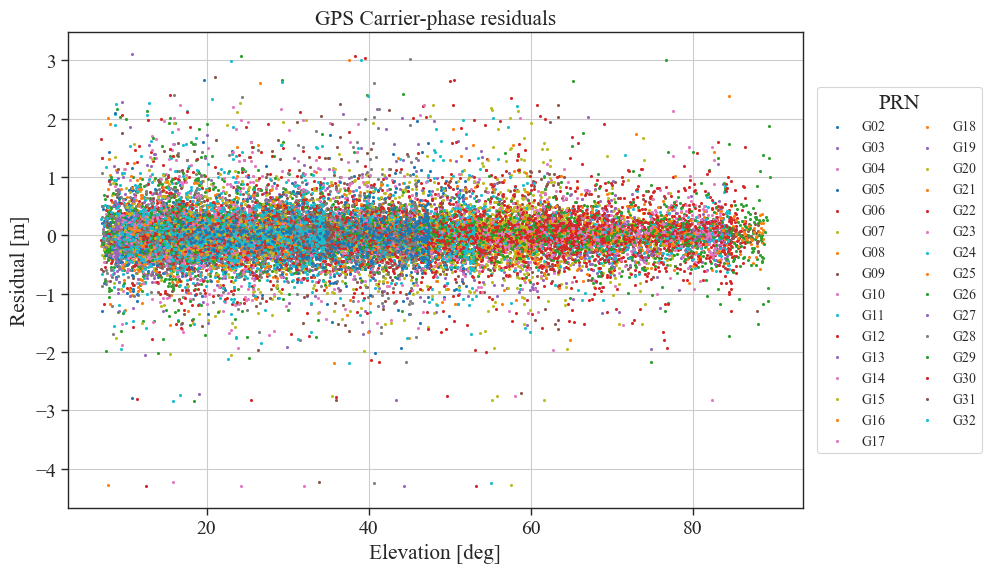

In [28]:
plot_residuals(df=residuals,obs_type='phase',x_axis='elev',skip_obs=10,cut_init_time=10)


As I mentioned in the $Introduction$ notebook, working in GNX-py mostly involves creating a configuration class and passing it to the management class. As you can see, this is also the case with PPP. I encourage you to try out other positioning modes and frequencies. If you are interested in how all this was implemented, I recommend that you study the scripts in the $gnx-py.ppp$ module. In the next notebook, we will discuss how to use GNX-py to monitor the quality of GNSS satellite orbits.